In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.auto import tqdm

In [2]:
import tensorflow_addons as tfa

/home/tmadula/.conda/envs/UKAEA/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# do we have a gpu 
gpu = torch.cuda.is_available()

if gpu:
    device = torch.cuda.current_device()
    print(f'GPU device: {device}')
else: 
    print('No GPU')


GPU device: 0


## Data Prep

In [4]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")
validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

In [5]:
keep_keys = ['ane', 'ate', 'autor', 'zeff', 'gammae', 
              'q', 'smag', 'alpha', 'ani1', 'ati0', 'ti_te0', 'x', 'normni1', 'machtor', 'lognustar', 'efiitg_gb']

In [6]:
train_data = train_data[keep_keys]
validation_data = validation_data[keep_keys]

nt, nv = train_data.shape[0], validation_data.shape[0]
nt_nan, nv_nan =  train_data['efiitg_gb'].isna().sum(), validation_data['efiitg_gb'].isna().sum()

train_data = train_data.dropna()
validation_data = validation_data.dropna()

assert train_data.shape[0] + nt_nan == nt
assert validation_data.shape[0] + nv_nan == nv

train_data['efiitg_gb'].loc[train_data['efiitg_gb'] != 0] = 1

validation_data['efiitg_gb'].loc[validation_data['efiitg_gb'] != 0] = 1

assert len(train_data['efiitg_gb'].unique()) == 2
assert len(validation_data['efiitg_gb'].unique()) == 2

# train_data = train_data.reset_index(drop=True)
# validation_data = validation_data.reset_index(drop=True);

In [7]:
# # Sort out class imbalances
# train_majority = train_data[train_data['efiitg_gb'] == 0]
# train_minority = train_data[train_data['efiitg_gb'] == 1]

# n_minority = train_minority.shape[0]

# # Downsample majority class
# train_maj_ds = resample(train_majority, 
#                                  replace=False,    # sample without replacement
#                                  n_samples=n_minority,     # to match minority class
#                                  random_state=123)     # reproducible results

# # Combine minority class with downsampled majority class
# df_downsampled = pd.concat([train_maj_ds, train_minority])

In [8]:
# df_downsampled.efiitg_gb.value_counts()

In [9]:
# split the data into inputs and output
# x_train, y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()
x_train, y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()
x_val, y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [10]:
# standard scaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform (x_val)

## Classifier (tensorflow implementation)

In [48]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [19]:
model = nn_classifier()

2022-02-19 16:07:15.950517: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-19 16:07:15.950925: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-19 16:07:15.951021: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [20]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

In [21]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['acc', f1])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=5, mode ='max')

In [22]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = 4096, epochs =80, callbacks=[stop_early], shuffle = True)

2022-02-19 16:07:18.089351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-19 16:07:18.090171: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


Epoch 1/80
4315/4315 [==============================] - 59s 13ms/step - loss: 0.2025 - acc: 0.9120 - f1_score: 0.8196 - val_loss: 0.1122 - val_acc: 0.9531 - val_f1_score: 0.9094
Epoch 2/80
4315/4315 [==============================] - 48s 11ms/step - loss: 0.1262 - acc: 0.9474 - f1_score: 0.8991 - val_loss: 0.1059 - val_acc: 0.9561 - val_f1_score: 0.9159
Epoch 3/80
4315/4315 [==============================] - 49s 11ms/step - loss: 0.1206 - acc: 0.9500 - f1_score: 0.9044 - val_loss: 0.1036 - val_acc: 0.9572 - val_f1_score: 0.9184
Epoch 4/80
4315/4315 [==============================] - 48s 11ms/step - loss: 0.1185 - acc: 0.9511 - f1_score: 0.9065 - val_loss: 0.1018 - val_acc: 0.9580 - val_f1_score: 0.9201
Epoch 5/80
4315/4315 [==============================] - 49s 11ms/step - loss: 0.1174 - acc: 0.9515 - f1_score: 0.9074 - val_loss: 0.1018 - val_acc: 0.9581 - val_f1_score: 0.9204
Epoch 6/80
4315/4315 [==============================] - 48s 11ms/step - loss: 0.1169 - acc: 0.9517 - f1_score:

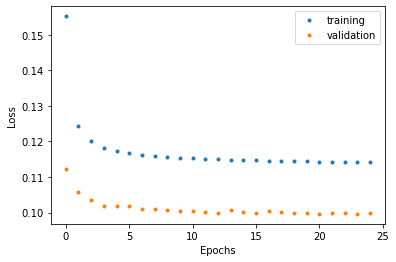

In [47]:
plt.figure()
plt.plot(history.history['loss'], '.', label = 'training')
plt.plot(history.history['val_loss'], '.',label = 'validation' )
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend()

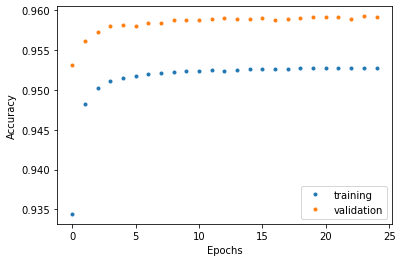

In [46]:
plt.figure()
plt.plot(history.history['acc'], '.', label = 'training')
plt.plot(history.history['val_acc'], '.', label = 'validation')
plt.xlabel('Epochs');
plt.ylabel("Accuracy");
plt.legend()

Text(0, 0.5, 'F1 Score')

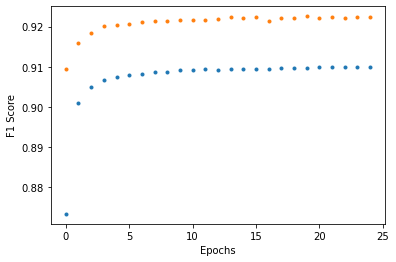

In [34]:
plt.figure()
plt.plot(history.history['f1_score'], '.')
plt.plot(history.history['val_f1_score'], '.')
plt.xlabel('Epochs');
plt.ylabel("F1 Score")

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [35]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl")

In [36]:
test_data = test_data[keep_keys]

nt = test_data.shape[0]
nt_nan =  test_data['efiitg_gb'].isna().sum()

test_data = test_data.dropna()

assert test_data.shape[0] + nt_nan == nt

test_data['efiitg_gb'].loc[test_data['efiitg_gb'] != 0] = 1

assert len(test_data['efiitg_gb'].unique()) == 2

In [37]:
x_test, y_test = test_data.iloc[:,:-1].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [38]:
x_test = scaler.transform(x_test)

In [40]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, predictions)

In [41]:
auc = roc_auc_score(y_test, predictions)

Text(0.8, 0.2, 'auc =  0.99')

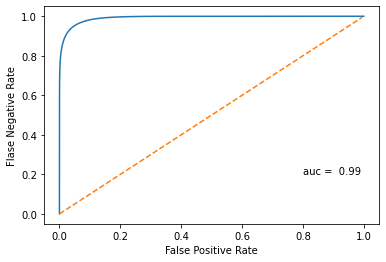

In [42]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

In [43]:
test_pred = np.where(predictions < 0.5, predictions, 1)
test_pred = np.where(predictions >= 0.5, test_pred, 0)

n_positive = np.where(y_test ==0)[0].shape[0]
n_negative = np.where(y_test ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

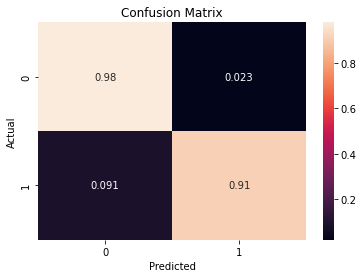

In [45]:
con_mat = confusion_matrix(y_test, test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

## Sanity check for val_loss > train_loss

In [53]:
model2 = nn_classifier()

In [54]:
f1 = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
model2.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['acc', f1])
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=5, mode ='max')

In [55]:
history2 = model2.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = 4096, epochs =80, callbacks=[stop_early], shuffle = True)

Epoch 1/80
4315/4315 [==============================] - 24s 5ms/step - loss: 0.1849 - acc: 0.9175 - f1_score: 0.8330 - val_loss: 0.1053 - val_acc: 0.9561 - val_f1_score: 0.9162
Epoch 2/80
4315/4315 [==============================] - 21s 5ms/step - loss: 0.1029 - acc: 0.9571 - f1_score: 0.9182 - val_loss: 0.0989 - val_acc: 0.9590 - val_f1_score: 0.9219
Epoch 3/80
4315/4315 [==============================] - 22s 5ms/step - loss: 0.0981 - acc: 0.9592 - f1_score: 0.9223 - val_loss: 0.0959 - val_acc: 0.9601 - val_f1_score: 0.9242
Epoch 4/80
4315/4315 [==============================] - 21s 5ms/step - loss: 0.0958 - acc: 0.9602 - f1_score: 0.9243 - val_loss: 0.0944 - val_acc: 0.9609 - val_f1_score: 0.9252
Epoch 5/80
4315/4315 [==============================] - 21s 5ms/step - loss: 0.0940 - acc: 0.9610 - f1_score: 0.9257 - val_loss: 0.0935 - val_acc: 0.9611 - val_f1_score: 0.9257
Epoch 6/80
4315/4315 [==============================] - 22s 5ms/step - loss: 0.0928 - acc: 0.9615 - f1_score: 0.926

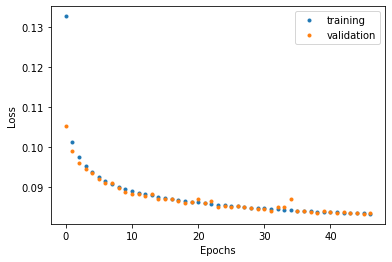

In [56]:
plt.figure()
plt.plot(history2.history['loss'], '.', label = 'training')
plt.plot(history2.history['val_loss'], '.',label = 'validation' )
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend()

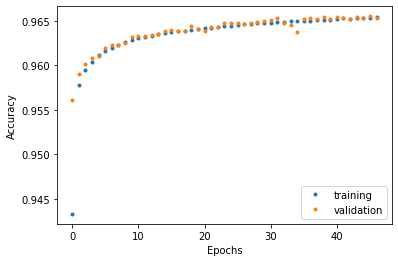

In [57]:
plt.figure()
plt.plot(history2.history['acc'], '.', label = 'training')
plt.plot(history2.history['val_acc'], '.', label = 'validation')
plt.xlabel('Epochs');
plt.ylabel("Accuracy");
plt.legend()

Text(0, 0.5, 'F1 Score')

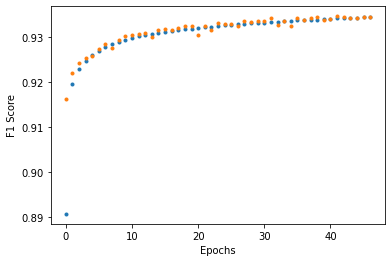

In [58]:
plt.figure()
plt.plot(history2.history['f1_score'], '.')
plt.plot(history2.history['val_f1_score'], '.')
plt.xlabel('Epochs');
plt.ylabel("F1 Score")